In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [2]:
import sys
import os

# Get the project root (one folder up from notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')

# Add to Python path
sys.path.append(src_path)

import crash_signature as cs



In [3]:
def normalize(p):
    p = np.array(p, dtype=float)
    p = np.maximum(p, 0)
    s = p.sum()
    return p / s

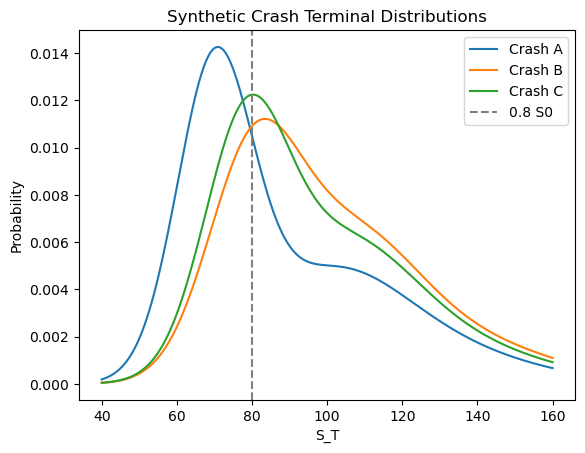

In [4]:
S0 = 100
S_grid = np.linspace(40, 160, 200)
# Crash A: very heavy left tail
pA_raw = (
    3.0 * np.exp(-0.5 * ((S_grid - 70) / 10)**2) +
    1.0 * np.exp(-0.5 * ((S_grid - 100) / 20)**2) +
    0.3 * np.exp(-0.5 * ((S_grid - 130) / 25)**2)
)
pA = normalize(pA_raw)

# Crash B: still left skewed but milder
pB_raw = (
    2.0 * np.exp(-0.5 * ((S_grid - 80) / 12)**2) +
    1.3 * np.exp(-0.5 * ((S_grid - 105) / 18)**2) +
    0.4 * np.exp(-0.5 * ((S_grid - 135) / 25)**2)
)
pB = normalize(pB_raw)

# Crash C: tune this to test classification
pC_raw = (
    2.2 * np.exp(-0.5 * ((S_grid - 78) / 11)**2) +
    1.2 * np.exp(-0.5 * ((S_grid - 103) / 19)**2) +
    0.35 * np.exp(-0.5 * ((S_grid - 132) / 26)**2)
)
pC = normalize(pC_raw)

plt.figure()
plt.plot(S_grid, pA, label="Crash A")
plt.plot(S_grid, pB, label="Crash B")
plt.plot(S_grid, pC, label="Crash C")
plt.axvline(0.8 * S0, color="grey", linestyle="--", label="0.8 S0")
plt.legend()
plt.xlabel("S_T")
plt.ylabel("Probability")
plt.title("Synthetic Crash Terminal Distributions")
plt.show()


In [5]:
sumA = cs.summarize_distribution(S_grid, pA, S0)
sumB = cs.summarize_distribution(S_grid, pB, S0)
sumC = cs.summarize_distribution(S_grid, pC, S0)

sumA, sumB, sumC

({'mean': 87.02626926363973,
  'std': 24.878554847543434,
  'skew': 0.8065532530289654,
  'kurtosis': -0.11880758155274673,
  'tail_prob_<0.8S0': 0.5059660444405384},
 {'mean': 97.70555148995456,
  'std': 23.45134366707528,
  'skew': 0.4888386451770193,
  'kurtosis': -0.3829464136599654,
  'tail_prob_<0.8S0': 0.2536701594607121},
 {'mean': 95.14540212174074,
  'std': 23.437271572041265,
  'skew': 0.595041230683718,
  'kurtosis': -0.2932144454562873,
  'tail_prob_<0.8S0': 0.3052096290052528})

In [6]:
signature = cs.build_crash_signature(sumA, sumB)
signature

{'tail_key': 'tail_prob_<0.8S0',
 'tail_thresh': 0.37981810195062526,
 'skew_thresh': 0.6476959491029923}

In [7]:
resA = cs.classify_crash(sumA, signature)
resB = cs.classify_crash(sumB, signature)
resC = cs.classify_crash(sumC, signature)

print("Crash A vs signature:", resA)
print("Crash B vs signature:", resB)
print("Crash C vs signature:", resC)


Crash A vs signature: {'is_crash_like': False, 'score': 0.2850052464158862, 'tail_val': 0.5059660444405384, 'skew_val': 0.8065532530289654, 'tail_thresh': 0.37981810195062526, 'skew_thresh': 0.6476959491029923}
Crash B vs signature: {'is_crash_like': True, 'score': 0.2850052464158862, 'tail_val': 0.2536701594607121, 'skew_val': 0.4888386451770193, 'tail_thresh': 0.37981810195062526, 'skew_thresh': 0.6476959491029923}
Crash C vs signature: {'is_crash_like': True, 'score': 0.12726319136464687, 'tail_val': 0.3052096290052528, 'skew_val': 0.595041230683718, 'tail_thresh': 0.37981810195062526, 'skew_thresh': 0.6476959491029923}


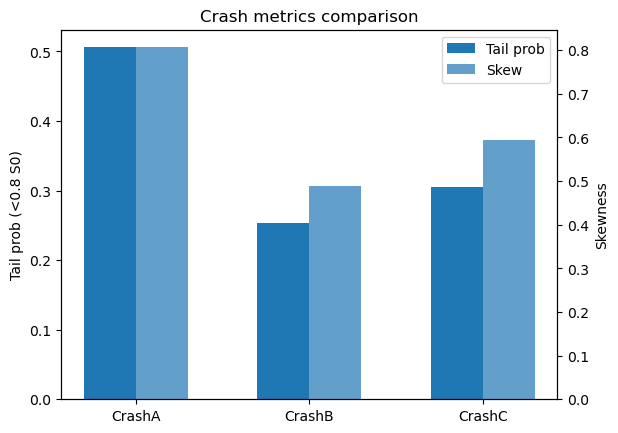

In [8]:
cs.plot_crash_metrics([sumA, sumB, sumC], ["CrashA", "CrashB", "CrashC"])


In [11]:
import json, os
from crash_signature import load_tree_summary, load_multiple_summaries

dummy_sum = {
    "crash_id": "Crash1",
    "S0": 100,
    "mean": sumA["mean"],
    "std": sumA["std"],
    "skew": sumA["skew"],
    "kurtosis": sumA["kurtosis"],
    "tail_prob_<0.8S0": sumA["tail_prob_<0.8S0"],
}
with open("../results/Crash1_summary.json", "w") as f:
    json.dump(dummy_sum, f, indent=2)

loaded = load_tree_summary("../results/Crash1_summary.json")
print(loaded)


{'crash_id': 'Crash1', 'S0': 100, 'mean': 87.02626926363973, 'std': 24.878554847543434, 'skew': 0.8065532530289654, 'kurtosis': -0.11880758155274673, 'tail_prob_<0.8S0': 0.5059660444405384}
